 ![First slide](https://drive.google.com/uc?export=download&id=17bVE5QnPUXyGnUlHkae06QHCSBR3Nx14)

## What is Ensemble?

A supervised *meta*-learning algorithm: 
1. It uses multiple learners (also called estimators)
1. Combines them to produce *better* results

## How do they work?

We're going to say that F is a learner if, for given a training set, $ X = {(x_i, y_i) \in \mathbb{R}^n \times \mathbb{R}} $, F gives us an estimation, $f$, of the underlying distribution, $P$. 

In other words, $f:\mathbb{R}^n \rightarrow \mathbb{R}$ is our *estimator* or *model*, trained on $X$ using the learner $F$. Some examples of learners:
* Linear Regression: takes in $(x_i, y_i)$ pairs and outputs a estimator in the form $f(x) = \beta_0 + \beta_1\cdot x$. The *learning* consists in attempting to find $\beta$ such that the $L_2$ error norm is minimized over $X$.
* Multilayer Perceptron: takes in $(x_i, y_i)$ pairs and, for a given architecture of a network, $f$, tries to minimize some loss function over our training set.

Suppose you have several learners:
\begin{equation}
F_1, F_2, \ldots, F_k
\end{equation}

### How could you combine them to get something better?

There are essentially 3 ways in which to do this. 
1. Bagging: average them to reduce variance
1. Boosting: exploit inter-dependence
1. Stacking: combine them using another learner

## 1. Bagging

Bagging is short for **Bootstrap Aggregation:** 

**Bootstrap method** is a statistical technique for estimating quantities about a population by averaging estimates from multiple small data samples

1. Repeat the following m times:
    * Bootstrap your training set (i.e. take a sub-sample with replacement)
    * Train one of your learners on this sample, producing $f_i$
2. Combine all of your models into a single model:
\begin{equation}
f(x) = \frac{1}{m}\sum_{i = 1}^m {f_i(x)}
\end{equation}

Bagging can be used with any base learners. 
* It reduces variance
* Turns unstable learners (such as decision trees) into stable learners
* It does not help as much when the base learners are already stable

One example of a famous bagging technique is Random Forest. Let's see how it works:
1. Take as learner a Decision Tree - e.g. ID3. 
1. Repeat M times:
    * Generate a bagging sample, while also sampling the features
    * Train ID3 on it, producing one decision tree
1. The resulting model is the average of all the decision trees (for classification, you would use **voting**)

In [11]:
from sklearn.exceptions import ConvergenceWarning
%matplotlib inline

import itertools
import pydotplus  # you can install pydotplus with: pip install pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

# Graphviz path for Windows
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

np.random.seed(0)

# Import data
df = pd.read_csv('..\data\input.csv.gz')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.70 (+/- 0.02) [K-NN]
Accuracy: 0.66 (+/- 0.02) [Bagging Tree]
Accuracy: 0.61 (+/- 0.02) [Bagging K-NN]


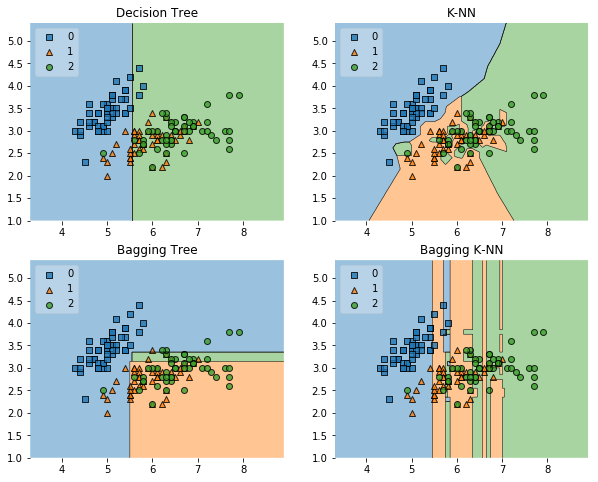

In [12]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=1) # an optimised version of the CART
knn_clf = KNeighborsClassifier(n_neighbors=1)

tree_bagging_clf = BaggingClassifier(base_estimator=tree_clf, n_estimators=10, max_samples=0.8, max_features=0.8)
knn_bagging_cls = BaggingClassifier(base_estimator=knn_clf, n_estimators=10, max_samples=0.8, max_features=0.8)
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [tree_clf, knn_clf, tree_bagging_clf, knn_bagging_cls]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

## 2. Boosting

**Boosting** refers to a family of algorithms which converts weak learner to strong learners.

The idea of boosting is to train weak learners, that have high bias, sequentially, each trying to correct its predecessor.

#### Boossting for binary class and regression
Train learners one on top of the other:
1. Learn using the existing training set, where we weigh each sample identically
1. Repeat m times:
    * Weigh samples based on the current error so far
    * Apply a new learner to the weighted train set
1. Output as model the sum of all trained models

#### Boosting for multi-class
The main flow of the algorithm is similar to the binary case, but a measure of the joint training error shall be defined in advance.

During each iteration the algorithm chooses a classifier of a single feature (features that can be shared by more categories shall be encouraged). This can be done via converting multi-class classification into a binary one (a set of categories versus the rest), or by introducing a penalty error from the categories that do not have the feature of the classifier.

Boosting helps reduce bias, but increases variance:
* It works well with stable learners
* It converts weak learners into strong learners
* Idea is that the family of weak learners should have a minimum correlation between them

The main differences between boosting and bagging:
1. Bagging trains in parallel. Boosting trains sequentially
1. Boosting exploits learner inter-dependence. Bagging exploits learner independence. 

Examples of algorithms: AdaBoost, Gradient Boosting, XGBoost

![Bagging vs Boosting](https://drive.google.com/uc?export=download&id=1SbQZQ31XZdX3z8zrKK2NlnCyFWziGdtV)

Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=1)]
Accuracy: 0.49 (+/- 0.01) [AdaBoost (n_est=2)]
Accuracy: 0.60 (+/- 0.02) [AdaBoost (n_est=3)]
Accuracy: 0.66 (+/- 0.13) [AdaBoost (n_est=10)]


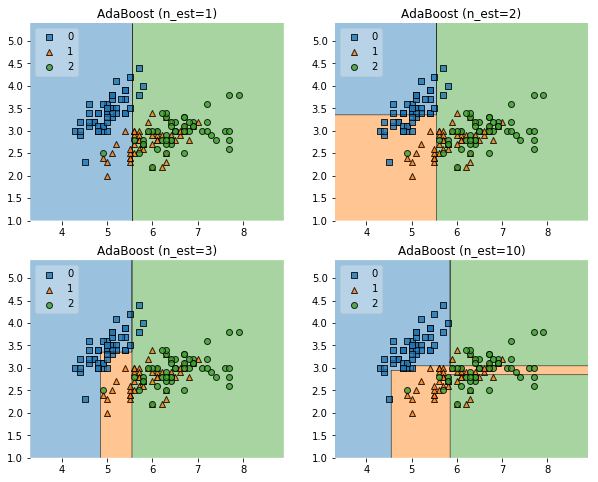

In [13]:
# We'll use AdaBoost here
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
np.random.seed(0)
    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 16]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    
    scores = cross_val_score(boosting, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each **base learner** consists of a **decision tree** with depth __$1$__, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

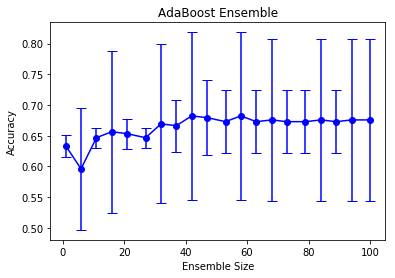

In [14]:
#Ensemble Size
num_est = list(map(int, np.linspace(1,100,20)))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
    
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble.

## 3. Stacking

__Stacking__ is a Meta Modeling Technique introduced by [Wolpert in 1992](http://www.machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf).


Combines the two methods, using two levels:
1. First, train your base learners similarly to bagging, obtaining $f_1, f_2, \ldots, f_m$
1. Enrich your data with the predictions made by these base learners:
\begin{equation}
    x = (x^1,\ldots,x^d) \rightarrow (x^1,\ldots,x^d, f_1(x), f_2(x), \ldots, f_m(x))
\end{equation}
1. Apply another learner on top of the extended data

It's important to note:
1. The final learner will be able to compute the residuals (errors) for each base learner. 
1. It might decide to average several base learners for a prediction (bagging), or offset their prediction for several examples (boosting)

![image.png](https://mlens.readthedocs.io/en/0.1.x/_images/network.png)
The input **X**  is either the original data or the previous layer’s output;

**Tr<sup>(j)</sup>** represents preprocessing pipelines that transform the input to its associated base learners **f<sup>(i)</sup>**.

The __Ft__ operation propagates specified features **s** from input to output.

Base learner predictions __p<sub>j</sub><sup>(i)</sup>__ are concatenated to propagated features __X<sub>:,s</sub>__ to form the output matrix __P__

In [15]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]


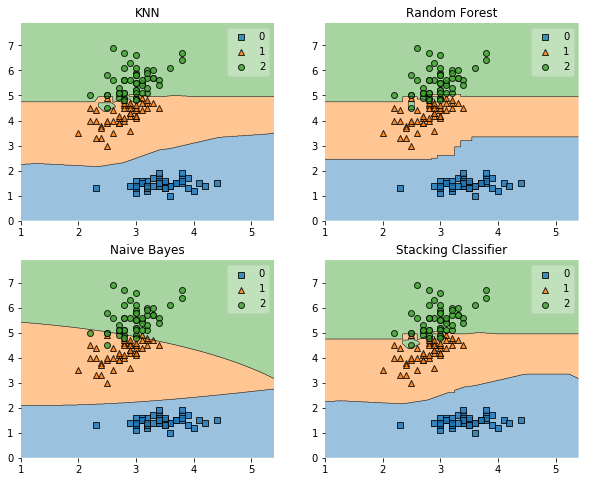

In [16]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

## SuperLearner

There is an issue with all the algorithms presented thus far:
* All model errors get evaluated on the same data the model is trained
* This can be corrected somewhat through sub-sampling
* But sub-sampling reduces training set size, which means you loose on efficiency

The idea for SuperLearner was initially hinted at in van der Laan and Dudoit's 2003 paper and developed in van der Laan's 2007 paper (https://pdfs.semanticscholar.org/4e81/f4c95dde9a327026c584b91a3fe691595d1f.pdf). Essentially, it states that **cross-fold validation** gives a good estimate for the error, so let's use that.

1. We define the CrossFold Validation operator $CV_F$:
    * Do k-fold on X: $K = \{ (X_T^i, X_V^i)| X_T^i \cup X_V^i = X, X_T^i\cap X_V^i = 0 \}$ such that $\cup_i X_V^i = X$ and $X_V^i \cap X_V^j = 0$
    * Apply $F_i$ on $X_T^i$
    * Apply $f_i$ on $X_V^i$: $CV_F(x) = f_i(x)$ where $x\in X_V^i$
1. We enrich our data using the CV operator:
\begin{equation}
x = (x^1,\ldots,x^d) \rightarrow (x^1,\ldots,x^d, CV_{F_1}(x), CV_{F_2}(x), \ldots, CV_{F_m}(x))
\end{equation}
1. We train on top of this another model, also known as the meta-model, $mf$.
1. Apply each base learner on $X$ and produce $f_1, \ldots, f_m$.
1. Output the model 
\begin{equation}
f(x) = mf(x, f_1(x), \ldots, f_m(x))
\end{equation}

#### Van der Laan **shows** that SuperLearner behaves **at worst** as the **best** base learner. 

![alt text](https://drive.google.com/uc?export=download&id=118Ch1L0ZL71OIcW9nNG2fOiRDcge6FNK)

## Why should I use it?

**You need to use cross-fold validation anyway!!**
* by partitioning the dataset, they scale better     
* Any ML pipeline should contain a CV fold stage that searches for the *best* learner
* You're already supposed to spend the resources on CV folding
* SuperLearner will simply squeeze that extra performance from the base learners
* by creating subset-specific base learners, they can harness local information better, possibly leading to a richer prediction input set for the meta learner.

## Following on an example: Political Donation Data

Let's follow through our proposed examples on a larger dataset.

Note that we split the data into train and test.

In [17]:
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


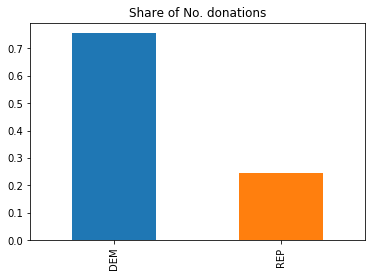

In [18]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")
plt.show()

# Play with it

We can try different parameters for it and see if it performs better.

Let's fit a decision tree with a single node (decision rule) on our training data and see how it perform on the test set:

In [19]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

Decision tree ROC-AUC score: 0.672


NameError: name 'print_graph' is not defined

Each of the two leaves register their share of training samples, the class distribution within their share, and the class label prediction. Our decision tree bases its prediction on whether the the size of the contribution is above #101.5: but it makes the same prediction regardless! This is not too surprising given that __75% of all donations are to Democrats__. But it's not making use of the data we have. Let's use __three levels__ of decision rules and see what we can get:

In [ ]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

print_graph(t2, xtrain.columns)

This model is not much better than the simple decision tree: a measly __5%__ of all donations are predicted to go to Republicans–far short of the __25% we would expect__.

A closer look tells us that the decision tree uses some __dubious splitting__ rules. A whopping 47.3% of all observations end up in the left-most leaf, while another 35.9% end up in the leaf second to the right. The vast majority of leaves are therefore __irrelevant__.

Making the model __deeper__ just causes it to __overfit__.

## What if we drop features?
A decision tree can be made more complex by increasing __"width"__, that is, creating several decision trees and combining them. 

In other words, an ensemble of decision trees.

To see why such a model would help, consider how we may force a decision tree to investigate other patterns than those in the above tree. The simplest solution is to remove features that appear early in the tree. Suppose for instance that we remove the transaction amount feature (transaction_amt), the root of the tree. Our new decision tree would look like this:

Projecting the data to a subset of features might not change much in the overall performance.

In [ ]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

#### But if you look at the correlation of the two, you will see that their errors are not very well correlated. 

In [ ]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

The second tree has learned something different from the first, with the same performance overall.
The share of Republican donation __increased to 7.3%__.
We now have two models that by themselves have __similar__ predictive power, but operate on __different rules__. Because of this, they are likely to make different prediction errors, which we can average out with an __ensemble__.

#### This means that the learner is not very stable.

**A chance for bagging to shine!**

In [ ]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

#### Take it all the way

Let's do a full-on Random Forest and see what happens.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features=5,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

## Errors Correlation

So we see that when errors don't correlate, we can use bagging to improve performance:
    * Different learners act well on different regions
    
Let's look at several learners and see how their errors correlate.

We first define a set of learners below.

In [ ]:
import time

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED, solver='lbfgs')
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED) #regression trees
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        _t0 = time.time()
        m.fit(xtrain, ytrain)
        dt = time.time()-_t0
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done in %.2f sec"%dt)

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

#### We look at their individual performance

In [ ]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

That's our baseline. The Gradient Boosting Machine (GBM) does best, followed by a simple logistic regression. For our ensemble strategy to work, prediction errors must be relatively uncorrelated. Checking that this holds is our first order of business:
#### Let's see those correlations

In [ ]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

Errors are significantly correlated, which is to be expected for models that perform well, since it's typically the outliers that are hard to get right. Yet most correlations are in the 50-80% span, so there is decent room for improvement.
#### How will the bagging ensemble work?

In [ ]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

#### Let's compare their ROC AUCs

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

In [ ]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

### Let's try to use Boosting
There's strength in diversity!

The only thing to consider is that the more models we add, the slower the ensemble will be.

#### Step 1: define a library of base learners

Here, we'll use our set of models from before

In [ ]:
base_learners = get_models()

#### Step 2: define a meta learner

Which meta learner to use is not obvious, but popular choices are linear models, kernel-based models (SVMs and KNNS) and decision tree based models.

But you could also use another ensemble as "meta learner": in this special case, you end up with a two-layer ensemble, akin to a feed-forward neural network.

To ensure the GBM explores local patterns, we are restricting each of the 1000 decision trees to train on a random subset of 4 base learners and 50% of input data. This way, the GBM will be exposed to each base learner's strength in different neighborhoods of the input space.


In [ ]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

#### Step 3: define a procedure for generating train and test sets
To keep things simple, we split the full training set into a training and prediction set of the base learners. This method is sometimes referred to as Blending. Unfortunately, the terminology differs between communities, so it's not always easy to know what type of cross-validation the ensemble is using.

In [ ]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

#### Step 4: train the base learners on a training set

In [ ]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")
            
train_base_learners(base_learners, xtrain_base, ytrain_base)

#### Step 5: generate base learners predictions

In [ ]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    _P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        _P[:, i] = p[:, 1]
        if verbose: print("done")

    return _P
P_base = predict_base_learners(base_learners, xpred_base)

#### Step 6: Train the meta learner
The prediction matrix P_base reflects test-time performance and can be used to train the meta learner

In [ ]:
meta_learner.fit(P_base, ypred_base)

Now that we have a firm understanding of ensemble learning, it's time to see what it can do to improve our prediction performance on the political contributions data set:

In [ ]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

As expected, the ensemble __beats the best estimator__ from our previous benchmark, but it doesn't beat the __simple average__ ensemble. That's because we trained the base learners and the meta learner __on only half the data__, so a lot of information is lost. To prevent this, we need to use a cross-validation strategy.

In [ ]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p_stacking_ens = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p_stacking_ens))

The upshot is that you should use a unit-tested package and focus on building your machine learning pipeline. In fact, once you've settled on a ensemble package, building ensembles becomes really easy: all you need to do is specify the base learners, the meta learner, and a method for training the ensemble.

In [ ]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))

In [ ]:
plot_roc_curve(ytest, p_sl[:, 1].reshape(-1, 1), P.mean(axis=1), ["Super Learner"], "Simple average")

### Where to go from here
There are many other types of ensembles than those presented here. However the basic ingredients are always the same: a library of base learners, a meta learner, and a training procedure. By playing around with these components, various specialized forms of ensembles can be created.

| Language  | Name         | Comment                                                                         |
|-----------|--------------|---------------------------------------------------------------------------------|
| Python    | ML-Ensemble  | General                                                                         |
| Python    | Scikit-learn | Bagging,                                                                        |
| Python    | mlxtend      | Regression                                                                      |
| Multiple  | H2O          | Distributed stacked ensemble learning. AutoML: Automatic Machine Learning       |
| Java      | StackNet     | Empowered by H20                                                                |
| Web-based | xcessiv      | Web-based ensemble learning                                                     |

#### Example of ensembles from a $10K Kaggle winning solution
![Kaggle example](https://drive.google.com/uc?export=download&id=1e-sSwu_FtgATF0m671VOV7IM1XAwxJaw)

Our solution is based in a 3-layer learning architecture as shown in the picture attached.

* 1st level: there are about 33 models that we used their predictions as meta features for the 2nd level, also there are 8 engineered features.
* 2nd level: there are 3 models trained using 33 meta features + 7 features from 1st level: XGBOOST, Neural Network(NN) and ADABOOST with ExtraTrees.
* 3rd level: it's composed by a weighted mean of 2nd level predictions.

All models in 1st layers are trained using a 5 fold cross-validation technique using always the same fold indices.


The 2nd level we trainned using 4 Kfold random indices. It provided us the ability to calculate the score before submitting to the leader board. All our cross-validate scores are extremely correlated with LB scores, so we have a good estimate of performance locally and it enabled us the ability to discard useless models for the 2nd learning level.


Models and features used for 2nd level training:

X = Train and test sets

* Model 1: RandomForest(R). Dataset: X
* Model 2: Logistic Regression(scikit). Dataset: Log(X+1)
* Model 3: Extra Trees Classifier(scikit). Dataset: Log(X+1) (but could be raw)
* Model 4: KNeighborsClassifier(scikit). Dataset: Scale( Log(X+1) )
* Model 5: libfm. Dataset: Sparse(X). Each feature value is a unique level.
* Model 6: H2O NN. Bag of 10 runs. Dataset: sqrt( X + 3/8) 
* Model 7: Multinomial Naive Bayes(scikit). Dataset: Log(X+1)
* Model 8: Lasagne NN(CPU). Bag of 2 NN runs. First with Dataset Scale( Log(X+1) ) and second with Dataset Scale( X )
* Model 9: Lasagne NN(CPU). Bag of 6 runs. Dataset: Scale( Log(X+1) )
* Model 10: T-sne. Dimension reduction to 3 dimensions. Also stacked 2 kmeans features using the T-sne 3 dimensions. Dataset: Log(X+1)
* Model 11: Sofia(R). Dataset: one against all with learner_type="logreg-pegasos" and loop_type="balanced-stochastic". Dataset: Scale(X)
* Model 12: Sofia(R). Trainned one against all with learner_type="logreg-pegasos" and loop_type="balanced-stochastic". Dataset: Scale(X, T-sne Dimension, some 3 level interactions between 13 most important features based in randomForest importance )
* Model 13: Sofia(R). Trainned one against all with learner_type="logreg-pegasos" and loop_type="combined-roc". Dataset: Log(1+X, T-sne Dimension, some 3 level interactions between 13 most important features based in randomForest importance )
* Model 14: Xgboost(R). Trainned one against all. Dataset: (X, feature sum(zeros) by row ). Replaced zeros with NA. 
* Model 15: Xgboost(R). Trainned Multiclass Soft-Prob. Dataset: (X, 7 Kmeans features with different number of clusters, rowSums(X==0), rowSums(Scale(X)>0.5), rowSums(Scale(X)< -0.5) )
* Model 16: Xgboost(R). Trainned Multiclass Soft-Prob. Dataset: (X, T-sne features, Some Kmeans clusters of X)
* Model 17: Xgboost(R): Trainned Multiclass Soft-Prob. Dataset: (X, T-sne features, Some Kmeans clusters of log(1+X) )
* Model 18: Xgboost(R): Trainned Multiclass Soft-Prob. Dataset: (X, T-sne features, Some Kmeans clusters of Scale(X) )
* Model 19: Lasagne NN(GPU). 2-Layer. Bag of 120 NN runs with different number of epochs.
* Model 20: Lasagne NN(GPU). 3-Layer. Bag of 120 NN runs with different number of epochs.
* Model 21: XGboost. Trained on raw features. Extremely bagged (30 times averaged).
* Model 22: KNN on features X + int(X == 0)
* Model 23: KNN on features X + int(X == 0) + log(X + 1)
* Model 24: KNN on raw with 2 neighbours
* Model 25: KNN on raw with 4 neighbours
* Model 26: KNN on raw with 8 neighbours
* Model 27: KNN on raw with 16 neighbours
* Model 28: KNN on raw with 32 neighbours
* Model 29: KNN on raw with 64 neighbours
* Model 30: KNN on raw with 128 neighbours
* Model 31: KNN on raw with 256 neighbours
* Model 32: KNN on raw with 512 neighbours
* Model 33: KNN on raw with 1024 neighbours
* Feature 1: Distances to nearest neighbours of each classes
* Feature 2: Sum of distances of 2 nearest neighbours of each classes
* Feature 3: Sum of distances of 4 nearest neighbours of each classes
* Feature 4: Distances to nearest neighbours of each classes in TFIDF space
* Feature 5: Distances to nearest neighbours of each classed in T-SNE space (3 dimensions)
* Feature 6: Clustering features of original dataset
* Feature 7: Number of non-zeros elements in each row
* Feature 8: X (That feature was used only in NN 2nd level training)

The 2nd level we start training cross-validated just to choose best models, tune hyperparameters and find optimum weights to average 3rd level.

After we found some good parameters, we trained 2nd level using entire trainset and bagged results.

The final model is a very stable 2nd level bagging of:

XGBOOST: 250 runs.

NN: 600 runs.

ADABOOST: 250 runs.

The average for the 3rd level we found better using a geometric mean of XGBOOST and NN. For ET we did an aritmetic mean with previous result: 0.85 * [XGBOOST^0.65 * NN^0.35] + 0.15 * [ET].

We tried a lot of training algorithms in first level as Vowpal Wabbit(many configurations), R glm, glmnet, scikit SVC, SVR, Ridge, SGD, etc... but none of these helped improving performance on second level.

Also we tried some preprocessing like PCA, ICA and FFT without improvement.

Also we tried Feature Selection without improvement. It seems that all features have positive prediction power.

Also we tried semi-supervised learning without relevant improvement and we discarded it due the fact that it have great potential to overfit our results.

Definetely the best algorithms to solve this problem are: Xgboost, NN and KNN. T-sne reduction also helped a lot. Other algorithm have a minor participation on performance. So we learn not to discard low performance algorithms, since it have enough predictive power to improve performance in a 2nd level training.

Our final cross-validated solution scored around 0.3962. LB(Public): 0.38055 and LB(Private): 0.38243.

Thanks for the ideas:
* https://pdfs.semanticscholar.org/4e81/f4c95dde9a327026c584b91a3fe691595d1f.pdf
* https://www.stat.berkeley.edu/users/laan/Class/Class_subpages/BASS_sec1_3.1.pdf
* https://blog.statsbot.co/ensemble-learning-d1dcd548e936
* http://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf

Thanks for the code: 
* https://www.dataquest.io/blog/introduction-to-ensembles/
* http://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf
* https://github.com/vsmolyakov/experiments_with_python/blob/master/chp01/ensemble_methods.ipynb